In [2]:
import numpy as np

from matplotlib import pyplot as plt

## Constants

In [3]:
# Constant values
d_em = 3.8e8
d_sm = 1.5e11
d_se = d_sm
R_e = 6.4e6

M_m = 7.35e22
M_s = 1.99e30
M_e = 5.97e27

G = 6.67e-11

GM_m = G*M_m
GM_s = G*M_s
GM_e = G*M_e

# Fixed positions
x_s = 0
y_s = 0
x_e = d_se
y_e = 0
x_m = d_se
y_m = d_em

## Initial conditions

In [10]:
xr_0 = d_se + R_e
yr_0 = 0
vrx_0 = 0
vry_0 = 10 # ~11.2 escape velocity

dt = 1
tar = np.arange(0,1000, dt)
xrar = np.zeros_like(tar)
yrar = np.zeros_like(tar)
vrxar = np.zeros_like(tar)
vryar = np.zeros_like(tar)

xrar[0] = xr_0
yrar[0] = yr_0
vrxar[0] = vrx_0
vryar[0] = vry_0

In [11]:

for tix, t in enumerate(tar[1:]):
    # Calculate total acceleration on the rocket
    # acc from earth
    dre = np.sqrt((xrar[tix]-x_e)**2 + (yrar[tix]-y_e)**2)
    drs = np.sqrt((xrar[tix]-x_s)**2 + (yrar[tix]-y_s)**2)
    drm = np.sqrt((xrar[tix]-x_m)**2 + (yrar[tix]-y_m)**2)

    # arx = GM_e*(xrar[tix]-x_e)/dre**3 + GM_s*(xrar[tix]-x_s)/drs**3 + GM_m*(xrar[tix]-x_m)/drm**3
    # ary = GM_e*(yrar[tix]-y_e)/dre**3 + GM_s*(yrar[tix]-y_s)/drs**3 + GM_m*(yrar[tix]-y_m)/drm**3

    arx = GM_e*(xrar[tix]-x_e)/dre**3 + GM_m*(xrar[tix]-x_m)/drm**3
    ary = GM_e*(yrar[tix]-y_e)/dre**3 + GM_m*(yrar[tix]-y_m)/drm**3

    vrxar[tix+1] = vrxar[tix] + dt*arx
    vryar[tix+1] = vryar[tix] + dt*ary
    xrar[tix+1] = xrar[tix] + dt*vrxar[tix]
    yrar[tix+1] = yrar[tix] + dt*vryar[tix]

/tmp/ipykernel_292/3154313624.py:5: RuntimeWarning: invalid value encountered in sqrt
  drs = np.sqrt((xrar[tix]-x_s)**2 + (yrar[tix]-y_s)**2)


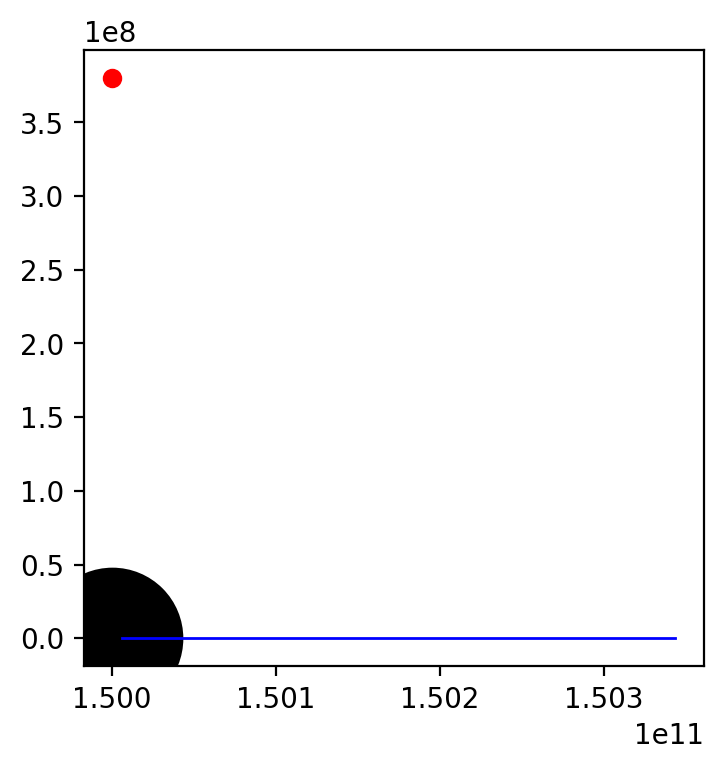

In [12]:
fig ,ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.plot(x_m, y_m, 'ro')
ax.plot(x_e, y_e, 'ko', ms=50)
ax.plot(xrar, yrar, 'b-', lw=1)